# I. Giới thiệu về RNN
- Là một mạng NN "hồi quy"

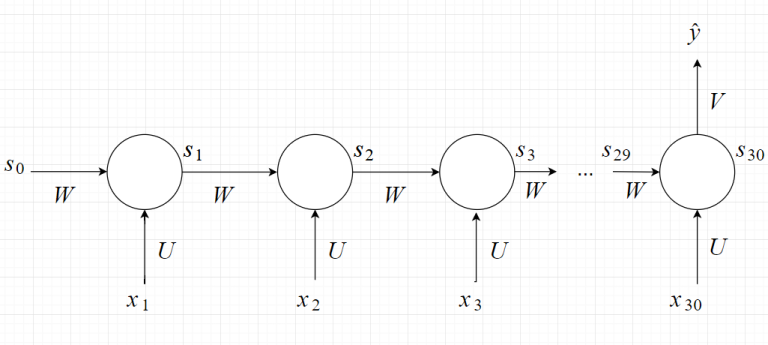

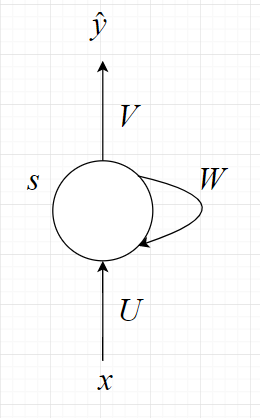

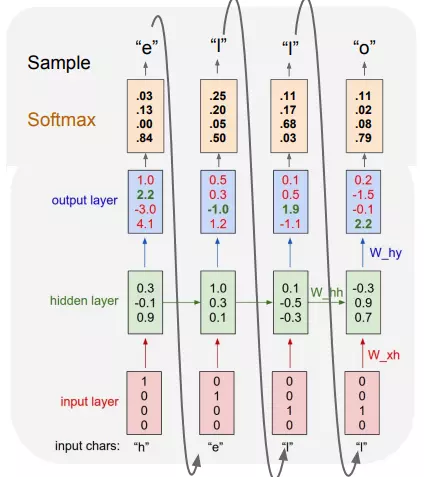

## Ứng dụng:
- Trong các bài toán dịch máy
- Bài toán nhận dạng giọng nói
- Bài toán sinh tiêu đề cho ảnh

## Một số cải tiến cho mạng RNN
- Các vấn đề của RNN thông thường
 + Thực hiện tuần tự
 + Vanishing gradient
- LSTM
 + Sử dụng 1 kênh để lưu trữ các thông tin xuyên suốt
 + Xây dựng các hàm liên quan: hàm forget, hàm input, output

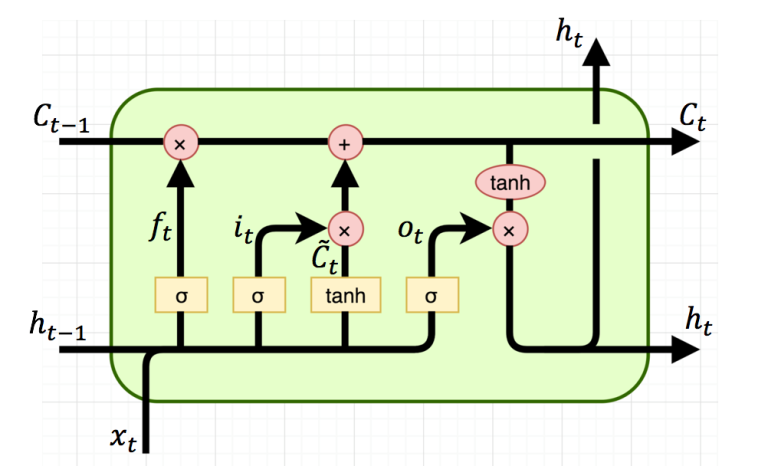

- GRU
 + Bổ sung cơ chế xác định khi nào cần xóa, hoặc khi nào cần cập nhật Hidden state thông qua các cổng.
 + Cổng xóa, cổng cập nhật

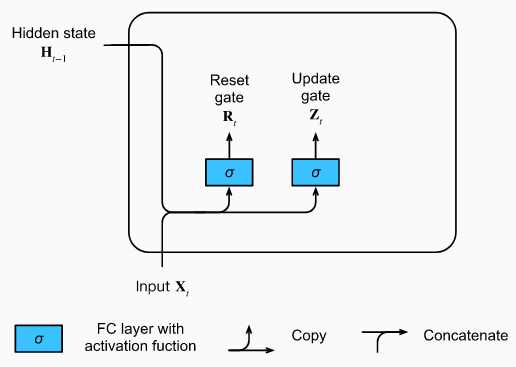

# II. Thực hành


1. Xây dựng bài toán phân loại cho MNIST sử dụng RNN. Trong đó:
    - Input: là dữ liệu ảnh MNIST.
    - Output: Xác định nhãn của ảnh
- Cách làm:
    + Data loader:
        + Chia train, val, test
        + Load ma trận điểm ảnh M
        + Ta xem xét dòng thứ i của ma trận M là 1 input theo thời gian tương ứng tại thời điểm t_i của mạng RNN.
    + Xây dựng class RNN để xác định nhãn của ảnh.


# Import thư viện và tải dữ liệu

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Định nghĩa transform để chuyển dữ liệu ảnh sang tensor và chuẩn hóa
transform = transforms.Compose([
    transforms.ToTensor(), # Chuyển dữ liệu ảnh sang Tensor
    transforms.Normalize((0.5,), (0.5,)) # Chuẩn hóa ảnh
])

# Tải dataset MNIST
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Chia dataset thành train, validation, và test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 384910393.51it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 15554146.61it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 193165136.90it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20484439.54it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Định nghĩa RNN

In [ ]:
# Use GPU if available

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {device}')
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Khởi tạo hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        # Forward qua RNN
        out, _ = self.rnn(x, h0)
        # Chỉ lấy kết quả của time step cuối cùng
        out = self.fc(out[:, -1, :])
        return out

# Khởi tạo mô hình
input_size = 28 # Số điểm ảnh trên mỗi dòng
hidden_size = 128 # Kích thước hidden state
output_size = 10 # Số lớp output (10 chữ số)
model = RNN(input_size, hidden_size, output_size).to(device)


Running on cuda


# Huẩn luyện RNN

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()  # Chế độ huấn luyện
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            # Chuyển đổi kích thước ảnh thành [batch_size, seq_length, input_size]
            images = images.view(-1, 28, 28).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward và optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Tính độ chính xác trên tập huấn luyện
        train_accuracy = 100 * correct / total
        val_accuracy = evaluate_accuracy(model, val_loader)  # Hàm đánh giá trên tập validation

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/total:.4f}, '
              f'Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')

def evaluate_accuracy(model, data_loader):
    model.eval()  # Chế độ đánh giá
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 28, 28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Khởi tạo mô hình và thiết lập cấu hình
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNN(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện mô hình
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Epoch [1/10], Loss: 0.0129, Train Accuracy: 72.46%, Val Accuracy: 83.97%
Epoch [2/10], Loss: 0.0058, Train Accuracy: 89.22%, Val Accuracy: 88.40%
Epoch [3/10], Loss: 0.0041, Train Accuracy: 92.58%, Val Accuracy: 91.88%
Epoch [4/10], Loss: 0.0033, Train Accuracy: 94.07%, Val Accuracy: 94.30%
Epoch [5/10], Loss: 0.0030, Train Accuracy: 94.62%, Val Accuracy: 94.07%
Epoch [6/10], Loss: 0.0028, Train Accuracy: 94.95%, Val Accuracy: 95.58%
Epoch [7/10], Loss: 0.0025, Train Accuracy: 95.48%, Val Accuracy: 95.37%
Epoch [8/10], Loss: 0.0024, Train Accuracy: 95.72%, Val Accuracy: 95.60%
Epoch [9/10], Loss: 0.0022, Train Accuracy: 95.97%, Val Accuracy: 95.05%
Epoch [10/10], Loss: 0.0021, Train Accuracy: 96.14%, Val Accuracy: 94.87%


In [ ]:
# Đếm số ảnh đã dự đoán
num_predicted = 0

# Lặp qua dữ liệu trong test_loader
for images, labels in test_loader:
    # Chuyển đổi kích thước ảnh cho phù hợp với mô hình RNN
    # Ví dụ, ảnh MNIST có kích thước là 28x28, ta xem mỗi dòng là một bước thời gian
    images = images.view(-1, 28, 28).to(device)
    labels = labels.to(device).to(device)
    # Đưa ảnh vào mô hình để nhận dự đoán
    outputs = model(images)

    # Lấy index của giá trị lớn nhất trong output là nhãn dự đoán
    _, predicted = torch.max(outputs, 1)

    # In ra nhãn gốc và nhãn dự đoán
    for i in range(images.size(0)):
        print(f"Ảnh {num_predicted+1}: Nhãn gốc: {labels[i]}, Nhãn dự đoán: {predicted[i]}")
        num_predicted += 1
        if num_predicted >= 10:
            break
    if num_predicted >= 10:
        break

Ảnh 1: Nhãn gốc: 9, Nhãn dự đoán: 9
Ảnh 2: Nhãn gốc: 6, Nhãn dự đoán: 6
Ảnh 3: Nhãn gốc: 6, Nhãn dự đoán: 6
Ảnh 4: Nhãn gốc: 0, Nhãn dự đoán: 0
Ảnh 5: Nhãn gốc: 9, Nhãn dự đoán: 9
Ảnh 6: Nhãn gốc: 9, Nhãn dự đoán: 9
Ảnh 7: Nhãn gốc: 3, Nhãn dự đoán: 3
Ảnh 8: Nhãn gốc: 6, Nhãn dự đoán: 6
Ảnh 9: Nhãn gốc: 6, Nhãn dự đoán: 6
Ảnh 10: Nhãn gốc: 7, Nhãn dự đoán: 7


## III. Tham khảo
- Xây dựng mô hình Image Captioning với CNN và LSTM https://www.kaggle.com/code/zohaib123/image-caption-generator-using-cnn-and-lstm
- Ý tưởng:
  + Dùng pretrained CNN để trích xuất đặc trưng ảnh
  + Dùng RNN (LSTM) để sinh từ từ các đặc trưng ảnh + từ phía trước nó